In [298]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(context='notebook', style='whitegrid', font_scale=1)

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet
from sklearn.metrics import r2_score
from sklearn.model_selection import (cross_val_score, train_test_split, 
                                     KFold, GridSearchCV)

# from sklearn import datasets
# from sklearn.datasets import load_diabetes

In [299]:
def isfloat_bedroom(row):
    try:
        f = float(row.Bedrooms)
        return f
    except ValueError:
        return row.Bathrooms

def feature_adj(merged_house_df):
    merged_house_df_test = merged_house_df.copy()
    try:
        #functin: fixed  bedroom loading problem (some values is put in 'Bathrooms')
        merged_house_df_test['Bedrooms'] = merged_house_df_test.apply(isfloat_bedroom,  axis=1)

        # update the Bathrooms to Full(1) + Half (0.5)
        merged_house_df_test['Bathrooms'] = merged_house_df_test['FullBath']*1 + merged_house_df_test['HalfBath']*0.5

        #add interactive features
        merged_house_df_test['SqrtUnitPrice'] = merged_house_df_test['SoldPrice'] / merged_house_df_test['HomeSize']
        merged_house_df_test = merged_house_df_test.drop(columns=['FullBath', 'HalfBath'], axis=1)
        
        #change to datetime type
        merged_house_df_test['SoldDate'] = pd.to_datetime(merged_house_df_test['SoldDate'])
        
        #reset column order
        merged_house_df = merged_house_df[['County', 'City','Zipcode','Population', 'Avg. Income/H/hold', 
                        'HomeType', 'Bedrooms', 'Bathrooms','FullBath','HalfBath','HomeSize', 'ParkingLotNum',
                        'YearBuilt', 'min_school_dist','avg_school_dist','RoomKitchenFeatures',
                        'SoldDate','Latitude', 'Longitude','SqrtUnitPrice','SoldPrice']]
    except:
        print("Already adjusted.")
    return merged_house_df_test.copy()

def data_feature_check(house_df): 
# find some extreme features ( may need to drop or adjust)
    noValue_cols=['Unnamed: 0']
    skrew_cols=[]
    noise_cols=[]
    for c in house_df.columns:
        try: 
            valid_data_cnt = sum(house_df[c].value_counts())
            # features with too mnany null value
            if valid_data_cnt < (len(house_df)*0.6):    
                noValue_cols.append(c)
            # features that 90% of data fall in one value - maybe
            if (house_df[c].value_counts().sort_values(ascending=False)[0] / valid_data_cnt) >= 0.9:
                skrew_cols.append(c)
            # features that > 60% of data have diff values 
            check_df = pd.DataFrame(house_df[c].value_counts()).reset_index()
            if len(check_df[check_df[c]==1]) > len(house_df)*0.6:
                noise_cols.append(c)    
        except Exception as e:
            print(e)
    print('noValue_cols:', noValue_cols)
    print('skrew_cols:', skrew_cols)
    print('noise_cols:', noise_cols)

def check_outlier_threshold(merged_house_df):
    #observe outlier threshold 
    fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharey=False)
   # fig.title('Observe Outlier threshold', horizontalalignment='center')

    # HomeSize
    sns.boxplot(ax=axes[0], x=merged_house_df['HomeSize'], orient="h", color='r')

    #ax[0] = sns.swarmplot( data=df_housing_merged['HomeSize'], color=".25")
    axes[0].set_title("Home Size" )
    axes[0].set(xlabel=None)
    # # SoldPrice
    sns.boxplot(ax=axes[1], x=merged_house_df['SoldPrice']/1000, orient="h", color='g')
    axes[1].set(xlabel=None)
    axes[1].set_title("Sold Price")

    # # home_sqrt_price  
    sns.boxplot(ax=axes[2], x=merged_house_df['SqrtUnitPrice'], orient="h", color='m')
    axes[2].set(xlabel=None)
    axes[2].set_title("Sqrt Unit price");
    
    
def pair_plt(df, plt_features):
    if plt_features:
        plt_df = df.loc[:,plt_features].copy()
    else: 
        plt_df = df
    sns.pairplot(plt_df, plot_kws=dict(alpha=.1, edgecolor='none'));


### 1. Load and clean data

In [332]:
#load data  features & 2158 rows
house_df=[]
house_df = pd.read_csv('./data/house_data_origin.csv')
house_df.shape
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3910 entries, 0 to 3909
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Addr                 3910 non-null   object 
 1   City                 3910 non-null   object 
 2   State                3910 non-null   object 
 3   Zipcode              3910 non-null   int64  
 4   SoldPrice            3910 non-null   int64  
 5   SoldDate             3910 non-null   object 
 6   HomeType             3910 non-null   object 
 7   Bedrooms             3910 non-null   object 
 8   Bathrooms            3910 non-null   int64  
 9   FullBath             3910 non-null   int64  
 10  HalfBath             3850 non-null   float64
 11  Flooring             3910 non-null   object 
 12  Heating              3910 non-null   object 
 13  Cooling              3910 non-null   object 
 14  Laundry              3910 non-null   object 
 15  HomeSize             3910 non-null   i

In [333]:
#drop duplicates
house_df = house_df.drop_duplicates(subset=['Addr', 'City', 'Zipcode','Bedrooms', 'YearBuilt', 'SoldDate', 'SoldPrice','HomeSize','LotSize', 'ParcelNum', 'URL'])
house_df = house_df.dropna(subset=['SoldPrice'])
house_df.shape

(2718, 40)

In [334]:
data_feature_check(house_df) 

0
0
0
0
0
0
0
0
0
0
noValue_cols: ['Unnamed: 0', 'latitude', 'longitude']
skrew_cols: ['State', 'WaterInfo']
noise_cols: ['Addr', 'ParcelNum', 'URL']


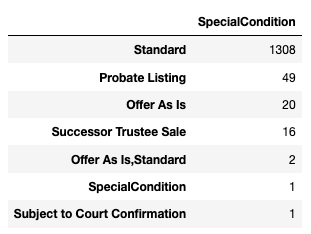

In [335]:
selected_features = ['City','Zipcode', 'SoldDate', 'HomeType', 
                    'Bedrooms','Bathrooms', 'FullBath','HalfBath', 'HomeSize',
                    'ParkingLotNum','YearBuilt','RoomKitchenFeatures',
                     'min_school_dist', 'avg_school_dist', 'SoldPrice']
smaller_house_df1 = house_df.loc[:,selected_features].copy()
smaller_house_df1.head(2)

,City,Zipcode,SoldDate,HomeType,Bedrooms,Bathrooms,FullBath,HalfBath,HomeSize,ParkingLotNum,YearBuilt,RoomKitchenFeatures,min_school_dist,avg_school_dist,SoldPrice
0,San Jose,95148,6/16/21,SingleFamily,3,3,2,1.0,1864,2,2000.0,Breakfast Area,0.3,0.50,1500000
1,San Jose,95148,6/24/21,SingleFamily,3,2,2,1.0,1153,2,1983.0,Breakfast Area,0.1,0.73,850000


In [336]:
smaller_house_df1.isna().sum()

City                     0
Zipcode                  0
SoldDate                 0
HomeType                 0
Bedrooms                 0
Bathrooms                0
FullBath                 0
HalfBath                25
HomeSize                 0
ParkingLotNum            0
YearBuilt               75
RoomKitchenFeatures    483
min_school_dist          0
avg_school_dist          0
SoldPrice                0
dtype: int64

In [337]:
smaller_house_df1 = smaller_house_df1.dropna(subset=['SoldPrice','YearBuilt'])
smaller_house_df1['HalfBath'] = smaller_house_df1['HalfBath'].fillna(0)
smaller_house_df1['RoomKitchenFeatures'] = smaller_house_df1['RoomKitchenFeatures'].fillna('Other')
smaller_house_df1.isna().sum()

City                   0
Zipcode                0
SoldDate               0
HomeType               0
Bedrooms               0
Bathrooms              0
FullBath               0
HalfBath               0
HomeSize               0
ParkingLotNum          0
YearBuilt              0
RoomKitchenFeatures    0
min_school_dist        0
avg_school_dist        0
SoldPrice              0
dtype: int64

In [338]:
print(smaller_house_df1.dtypes)

City                    object
Zipcode                  int64
SoldDate                object
HomeType                object
Bedrooms                object
Bathrooms                int64
FullBath                 int64
HalfBath               float64
HomeSize                 int64
ParkingLotNum            int64
YearBuilt              float64
RoomKitchenFeatures     object
min_school_dist        float64
avg_school_dist        float64
SoldPrice                int64
dtype: object


In [369]:
# merge with CA median income and populatin data & County
median_income_df = pd.read_csv("./data/MedianIncome_CA.csv")
drop_cols = ['row', 'City', 'National Rank']
median_income_df = median_income_df.drop(columns=drop_cols, axis=1)
merged_house_df = smaller_house_df1.merge(median_income_df, on = 'Zipcode')
county_df = pd.read_csv("./data/zip_county.csv")
county_df = county_df.drop(columns='CITY', axis=1)
merged_house_df = merged_house_df.merge(county_df, on = 'Zipcode')
merged_house_df = feature_adj(merged_house_df)
merged_house_df

Already adjusted.


,City,Zipcode,SoldDate,HomeType,Bedrooms,Bathrooms,HomeSize,ParkingLotNum,YearBuilt,RoomKitchenFeatures,min_school_dist,avg_school_dist,SoldPrice,Latitude,Longitude,Population,Avg. Income/H/hold,County,SqrtUnitPrice
0,San Jose,95148,2021-06-16,SingleFamily,3.0,2.5,1864,2,2000.0,Breakfast Area,0.3,0.50,1500000,37.339533,-121.777179,44095,89398.0,Santa Clara,804.721030
1,San Jose,95148,2021-06-24,SingleFamily,3.0,2.5,1153,2,1983.0,Breakfast Area,0.1,0.73,850000,37.339533,-121.777179,44095,89398.0,Santa Clara,737.207285
2,San Jose,95148,2021-07-02,SingleFamily,4.0,3.5,2478,2,1970.0,Breakfast Area,0.4,0.93,1400000,37.339533,-121.777179,44095,89398.0,Santa Clara,564.971751
3,San Jose,95148,2021-08-26,SingleFamily,2.0,2.5,1341,2,1968.0,Breakfast Area,0.1,0.30,1300000,37.339533,-121.777179,44095,89398.0,Santa Clara,969.425802
4,San Jose,95148,2021-09-07,SingleFamily,5.0,2.5,2072,2,1977.0,Breakfast Area,0.6,0.83,1634000,37.339533,-121.777179,44095,89398.0,Santa Clara,788.610039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2542,Palo Alto,94306,2021-06-11,Condo,4.0,3.5,2121,1,2014.0,Breakfast Area,0.6,0.93,2642000,37.416159,-122.131337,24484,82314.0,Santa Clara,1245.638850
2543,Palo Alto,94306,2021-06-10,SingleFamily,3.0,3.5,2292,1,1996.0,Breakfast Area,0.6,0.93,4250000,37.416159,-122.131337,24484,82314.0,Santa Clara,1854.275742
2544,Palo Alto,94306,2021-06-09,SingleFamily,4.0,3.5,2820,1,1952.0,Breakfast Area,0.1,0.77,4850000,37.416159,-122.131337,24484,82314.0,Santa Clara,1719.858156
2545,Palo Alto,94306,2021-06-09,Townhouse,2.0,3.5,1116,1,1978.0,Breakfast Area,0.7,1.00,1050000,37.416159,-122.131337,24484,82314.0,Santa Clara,940.860215


### - Filter out some irregular data 

In [370]:
merged_house_df.sort_values(by=['Bedrooms']).head(2)

,City,Zipcode,SoldDate,HomeType,Bedrooms,Bathrooms,HomeSize,ParkingLotNum,YearBuilt,RoomKitchenFeatures,min_school_dist,avg_school_dist,SoldPrice,Latitude,Longitude,Population,Avg. Income/H/hold,County,SqrtUnitPrice
1636,Berkeley,94703,2021-08-06,SingleFamily,0.0,2.5,2588,4,1924.0,"Granite Counters, Breakfast Area",0.7,1.03,1320000,37.863843,-122.275684,19743,43640.0,Alameda,510.046368
515,San Jose,95113,2021-01-28,Condo,0.0,1.5,673,1,2008.0,Breakfast Area,0.3,1.60,577500,37.333851,-121.891147,543,12083.0,Santa Clara,858.098068


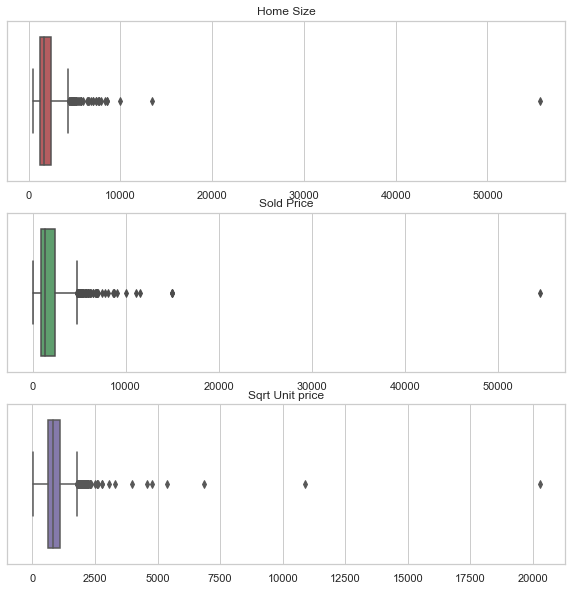

In [371]:
check_outlier_threshold(merged_house_df)

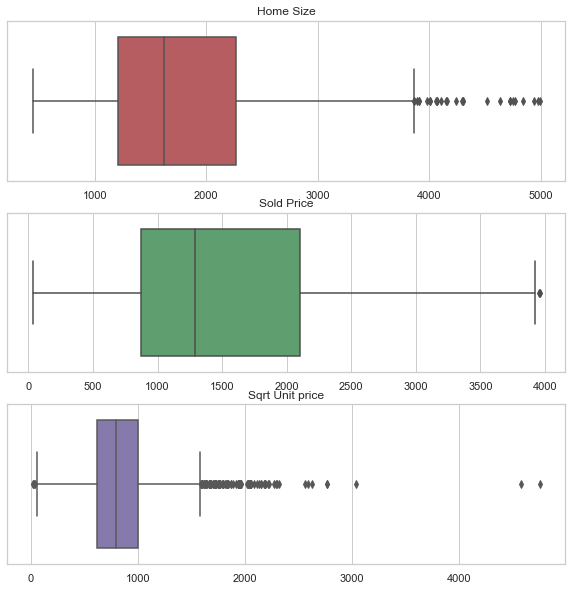

In [389]:
# drop na rows ex: df_housing_merged_adj.dropna(subset=["PREV_DATE"], axis=0, inplace=True)
# remove rows with 0 bedrooms
merged_house_df = merged_house_df.loc[merged_house_df['HomeSize'] < 5000,:]
merged_house_df = merged_house_df.loc[merged_house_df['Bedrooms'] > 0,:]
merged_house_df = merged_house_df.loc[merged_house_df['YearBuilt'] > 0,:]
merged_house_df = merged_house_df.loc[merged_house_df['SoldPrice'] < 4000000,:]
merged_house_df = merged_house_df.loc[merged_house_df['SoldPrice'] > 20000,:]
check_outlier_threshold(merged_house_df)

### 2. Features Engineering & Build a baseline mode

In [390]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.metrics import mean_absolute_error

def diagnostic_plots(y_pred, y_true, resid):
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))

    g1 = sns.regplot(x=y_pred, y=y_true, ci=False, fit_reg=False, line_kws={'color': 'blue'}, ax=axes[0], scatter_kws={'s': 5})
    g1.set_xlabel('Predicted Target')
    g1.set_ylabel('True Target')
    g1.plot(y_true, y_true, '--', color='gray')

    g2 = sns.regplot(x=y_pred, y=resid, lowess=True, ax=axes[1], line_kws={'color': 'red'}, scatter_kws={'s': 5})
    g2.set_xlabel('Predicted Target')
    g2.set_ylabel('Residual')
    g2.axhline(y=0, color='gray', linestyle='--')

    stats.probplot(resid, dist="norm", plot=axes[2])

    fig.suptitle('Diagnostic Plots');
    fig.tight_layout();

def split_and_validate(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''    
        # Split into train, val, and test
    X_tr, X_test, y_tr, y_test  = \
    train_test_split(X, y, test_size=0.2, random_state=55)
  
    X_train, X_val, y_train, y_val = \
        train_test_split(X_tr, y_tr, test_size=0.25, random_state=55)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    train_score = lr_model.score(X_train, y_train)
    # score fit model on validation data,  get predict and redidual value 
    val_score = lr_model.score(X_val, y_val)
    test_score = lr_model.score(X_test, y_test)
    y_test_pred = lr_model.predict(X_test)
    resid =  y_test - y_test_pred
    # report results
    print('Train R^2 score was:', train_score)
    print('\nValidation R^2 score was:', val_score) 
    print('\nTest R^2 score was:', test_score)
    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}') 
    
    y_pred = lr_model.predict(X_val)
     
    my_mae = mean_absolute_error(y_val, y_pred)
    
    print('\nMAE:', my_mae)
    # Plot Y-predict vs Y-Actual
    plt.plot(y_train, y_train, color = 'red')
    plt.scatter(y_test, y_test_pred, alpha=.1)
    plt.ticklabel_format(style='plain') 
    plt.plot([0, 200], [0, 200])
    plt.savefig('Plot-Fitted_vs_Actual_TestSet')
    
    #Diagnosis
    diagnostic_plots(y_test_pred, y_test,resid )
    
def vif(df_X):
    '''
    Calculate the VIF for each feature of df_X (a Pandas DataFrame).
    Measure how much the variance of the $j$th coefficient is affected by changes in the other predictors. 
    '''
    vif_data = [variance_inflation_factor(df_X.values, i)
                for i in range(df_X.shape[1])]
    
    return pd.Series(vif_data, index=df_X.columns)


def statsmodel(X, y):
    #Create the model
    model = sm.OLS(y, sm.add_constant(X)) 

    #Fit
    fit = model.fit()

    print(fit.summary())

In [391]:
merged_house_df.head(5)

,City,Zipcode,SoldDate,HomeType,Bedrooms,Bathrooms,HomeSize,ParkingLotNum,YearBuilt,RoomKitchenFeatures,min_school_dist,avg_school_dist,SoldPrice,Latitude,Longitude,Population,Avg. Income/H/hold,County,SqrtUnitPrice
0,San Jose,95148,2021-06-16,SingleFamily,3.0,2.5,1864,2,2000.0,Breakfast Area,0.3,0.50,1500000,37.339533,-121.777179,44095,89398.0,Santa Clara,804.721030
1,San Jose,95148,2021-06-24,SingleFamily,3.0,2.5,1153,2,1983.0,Breakfast Area,0.1,0.73,850000,37.339533,-121.777179,44095,89398.0,Santa Clara,737.207285
2,San Jose,95148,2021-07-02,SingleFamily,4.0,3.5,2478,2,1970.0,Breakfast Area,0.4,0.93,1400000,37.339533,-121.777179,44095,89398.0,Santa Clara,564.971751
3,San Jose,95148,2021-08-26,SingleFamily,2.0,2.5,1341,2,1968.0,Breakfast Area,0.1,0.30,1300000,37.339533,-121.777179,44095,89398.0,Santa Clara,969.425802
4,San Jose,95148,2021-09-07,SingleFamily,5.0,2.5,2072,2,1977.0,Breakfast Area,0.6,0.83,1634000,37.339533,-121.777179,44095,89398.0,Santa Clara,788.610039


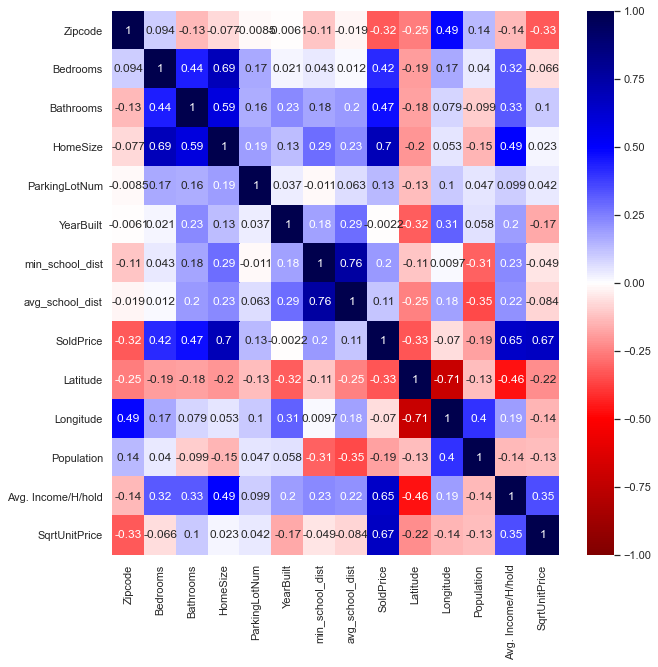

In [392]:
upper = np.triu(merged_house_df.corr())  # optionally, you can just look at the lower triangle

f, ax = plt.subplots(figsize=(10, 10))
merged_house_df.corr()
ax = sns.heatmap(merged_house_df.corr(), cmap="seismic_r", annot=True, vmin=-1, vmax=1);

Train R^2 score was: 0.6583493664076003

Validation R^2 score was: 0.6431765158877285

Test R^2 score was: 0.6706111103944614
Feature coefficient results: 

Bedrooms : -122288.17
Bathrooms : 142907.34
HomeSize : 688.11
ParkingLotNum : 30114.51
YearBuilt : -4591.75
min_school_dist : 107407.73
avg_school_dist : -196946.45
Population : -3.73
Avg. Income/H/hold : 13.13

MAE: 383584.19269347936


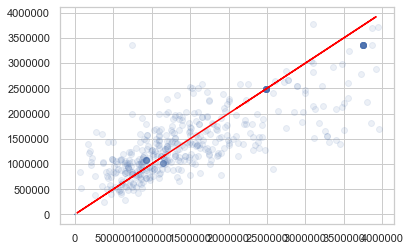

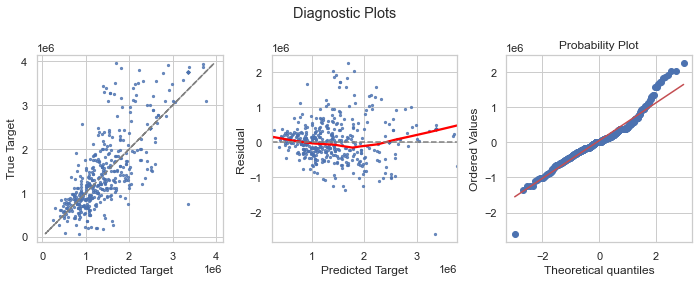

In [393]:
#'HomeType', ,'RoomKitchenFeatures', 'SoldDate', 
plt_features1 = ['Bedrooms','Bathrooms', 'HomeSize',
                'ParkingLotNum','YearBuilt', 
                'min_school_dist', 'avg_school_dist', 'Population',
                     'Avg. Income/H/hold', 'SoldPrice']
X1 =  merged_house_df.loc[:,plt_features1]
y = X1['SoldPrice']
#feature_X1 = X1.iloc[:,:len(X1.columns)-1]
feature_X1 = X1.drop(columns=['SoldPrice'])
split_and_validate(feature_X1 , y)

#pair_plt(merged_house_df, plt_features)

In [394]:
vif(X1)  #Bedrooms & Bathrooms are very related

Bedrooms              18.828915
Bathrooms             22.869290
HomeSize              24.930456
ParkingLotNum          6.034555
YearBuilt             29.744814
min_school_dist        6.680220
avg_school_dist       10.289633
Population             5.078421
Avg. Income/H/hold    14.838216
SoldPrice             10.422451
dtype: float64

In [395]:
statsmodel(feature_X1,y)

                            OLS Regression Results                            
Dep. Variable:              SoldPrice   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                     508.3
Date:                Fri, 01 Oct 2021   Prob (F-statistic):               0.00
Time:                        07:08:45   Log-Likelihood:                -34755.
No. Observations:                2375   AIC:                         6.953e+04
Df Residuals:                    2365   BIC:                         6.959e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               9.461e+06   8.93

Train R^2 score was: 0.6583493664076003

Validation R^2 score was: 0.6431765158876566

Test R^2 score was: 0.6706111103944058
Feature coefficient results: 

Bedrooms : -122288.17
Bathrooms : 142907.34
HomeSize : 688.11
ParkingLotNum : 30114.51
YearBuilt : -2295.88
min_school_dist : 107407.73
avg_school_dist : -196946.45
Population : -3.73
Avg. Income/H/hold : 13.13
HomeAge : 2295.88

MAE: 383584.1926936666


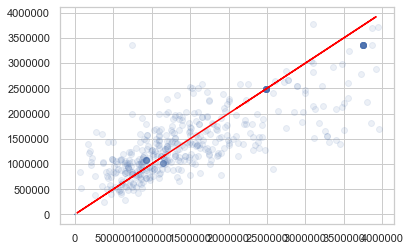

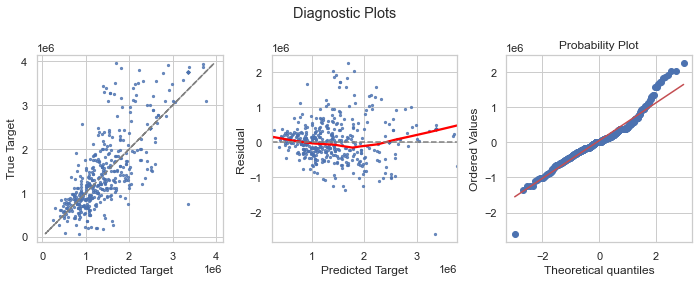

In [396]:
X2 = X1.copy()
currentYear = datetime.now().year
X2['HomeAge'] = currentYear - merged_house_df['YearBuilt'] 
y = X2['SoldPrice']
feature_X2 = X2.drop(columns=['SoldPrice'])
split_and_validate(feature_X2 , y)

Train R^2 score was: 0.6670938195895082

Validation R^2 score was: 0.6536328046967166

Test R^2 score was: 0.6755048762623574
Feature coefficient results: 

Bedrooms : -112271.72
Bathrooms : 151203.64
HomeSize : 654.75
ParkingLotNum : 25844.89
YearBuilt : -2103.62
min_school_dist : 4790.06
avg_school_dist : -126040.12
Population : -2.72
Avg. Income/H/hold : -2.82
HomeAge : 2103.62
AVgIncome^2 : 0.00

MAE: 366567.6778452061


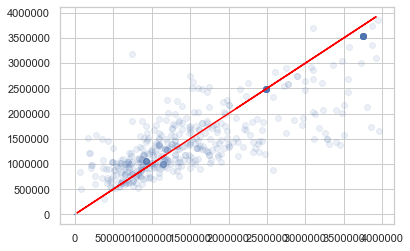

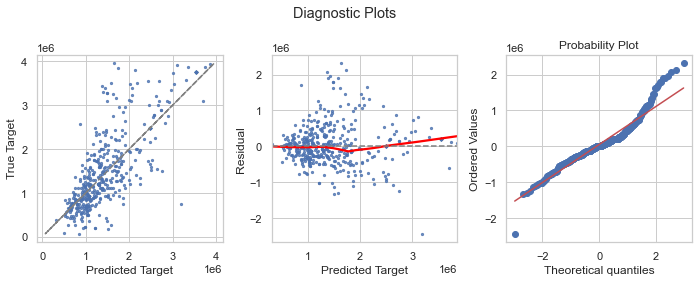

In [397]:
#Poly feature
import math
X3 = X2.copy()

X3['AVgIncome^2'] = merged_house_df['Avg. Income/H/hold']**2 
y = X3['SoldPrice']
feature_X3 = X3.drop(columns=['SoldPrice'])

split_and_validate(pd.get_dummies(feature_X3, drop_first=True), y)

Train R^2 score was: 0.6952344308214431

Validation R^2 score was: 0.6917160040003392

Test R^2 score was: 0.6964360549353941
Feature coefficient results: 

Bedrooms : -132501.83
Bathrooms : 139721.88
HomeSize : 583.04
ParkingLotNum : 33815.85
YearBuilt : -562.02
min_school_dist : 78426.00
avg_school_dist : -158646.37
Population : -3.99
Avg. Income/H/hold : -4.51
HomeAge : 562.02
AVgIncome^2 : 0.00
HomeType_Condo : 2213.50
HomeType_MobileManufactured : -556871.33
HomeType_MultiFamily : 161279.22
HomeType_SingleFamily : 396301.58
HomeType_Townhouse : 149326.76

MAE: 343150.9169707878


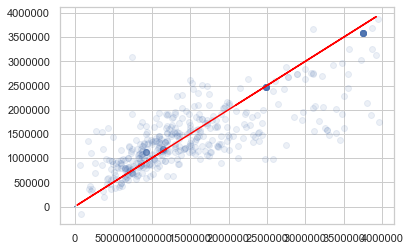

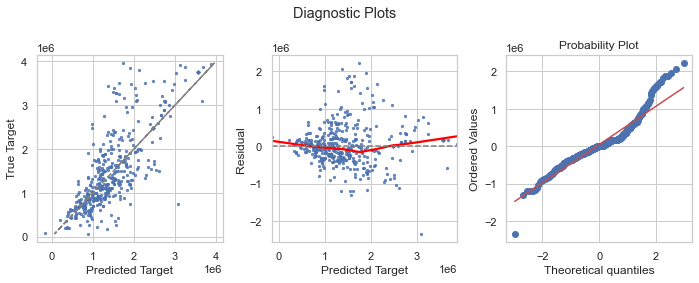

In [398]:
#get dummies for HomeType
X4 = X3.copy()

X4['HomeType'] = merged_house_df['HomeType']
y = X4['SoldPrice']
feature_X4 = X4.drop(columns=['SoldPrice'])

split_and_validate(pd.get_dummies(feature_X4, drop_first=True), y)

### 2.1 Feature engineering result

Train R^2 score was: 0.8318208661910567

Validation R^2 score was: 0.813083518076028

Test R^2 score was: 0.8119095764724515
Feature coefficient results: 

Bedrooms : -43377.69
Bathrooms : 43068.35
HomeSize : 554.36
ParkingLotNum : 10754.04
YearBuilt : -576.97
min_school_dist : -61813.89
Avg. Income/H/hold : -12.17
HomeAge : 592.51
AVgIncome^2 : 0.00
HomeType_Condo : -58333.47
HomeType_MobileManufactured : -602202.87
HomeType_MultiFamily : 59415.23
HomeType_SingleFamily : 412539.02
HomeType_Townhouse : 25271.89
City_ Albany : 318326.44
City_ Alviso : -42606.94
City_ Berkeley : 64717.20
City_ Campbell : 399325.84
City_ Castro Valley : -509193.87
City_ Cupertino : 787500.17
City_ Dublin : -6543.02
City_ East Palo Alto : -107750.59
City_ Emeryville : 38772.56
City_ Fremont : 138080.66
City_ Gilroy : -359450.59
City_ Hayward : -157156.18
City_ Kensington : -219043.62
City_ Livermore : -184712.97
City_ Los Altos : 700890.99
City_ Los Altos Hills : -811313.33
City_ Los Gatos : 430369.12
City

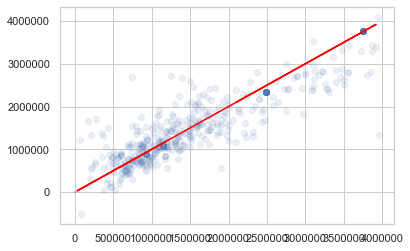

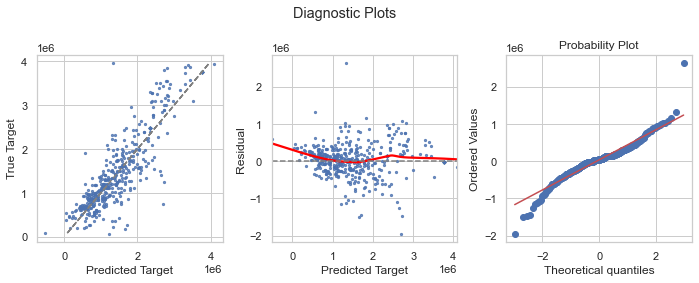

In [399]:
#get dummies for HomeType
X5 = X4.copy()

X5['City'] = merged_house_df['City']
y5 = X5['SoldPrice']
feature_X5 = X5.drop(columns=['SoldPrice','avg_school_dist','Population'])

split_and_validate(pd.get_dummies(feature_X5, drop_first=True), y5)

### 2.2 Kfold Cross validation
 - not as good as 2.1

In [384]:
    X3.columns

Index(['Bedrooms', 'Bathrooms', 'HomeSize', 'ParkingLotNum', 'YearBuilt',
       'min_school_dist', 'avg_school_dist', 'Population',
       'Avg. Income/H/hold', 'SoldPrice', 'HomeAge', 'AVgIncome^2'],
      dtype='object')

[0.67022045 0.65567738 0.63229019 0.64129342 0.6526456 ]
Linear Reg Mean Score:  0.6504254094229254
Feature coefficient results: 

Bedrooms : -105646.29
Bathrooms : 185835.23
HomeSize : 781.62
ParkingLotNum : 10783.58
YearBuilt : -2044.62
min_school_dist : -65286.01
avg_school_dist : -168789.14
Population : -2.62
Avg. Income/H/hold : -0.98
SoldPrice : 2044.62
HomeAge : 0.00

MAE: 432387.9188332607


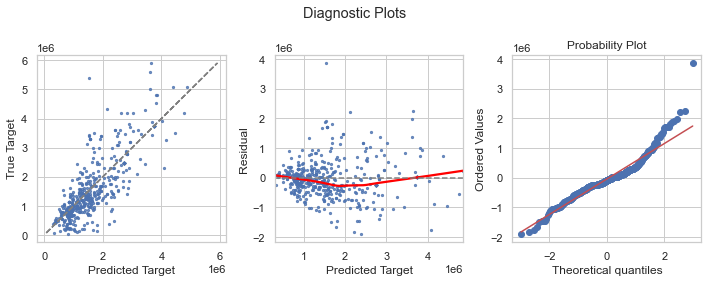

In [385]:
X_test = X3.copy()
y = X_test['SoldPrice']
#Split into train, val, and test
X, X_test, y, y_test = train_test_split(X_test.drop(columns=['SoldPrice',]), 
                                        y, test_size=0.2, random_state=40)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=40)

#Split Training Data into Multiple Folds

kfold = KFold(n_splits=5, shuffle=True, random_state=0)

lin_reg_est = LinearRegression()
scores = cross_val_score(lin_reg_est, X_train, y_train, cv=kfold)
print(scores)
print("Linear Reg Mean Score: ", np.mean(scores))
# Build the Model
lin_reg_est.fit(X_train, y_train)

y_test_pred = lin_reg_est.predict(X_test)

resid =  y_test - y_test_pred
train_score = lin_reg_est.score(X_train, y_train)
    # score fit model on validation data,  get predict and redidual value 
val_score = lin_reg_est.score(X_val, y_val)


print('Feature coefficient results: \n')
for feature, coef in zip(X3.columns, lin_reg_est.coef_):
    print(feature, ':', f'{coef:.2f}') 

y_pred = lin_reg_est.predict(X_test)

my_mae = mean_absolute_error(y_test, y_pred)

print('\nMAE:', my_mae)
# # Plot Y-predict vs Y-Actual
# plt.plot(y_train, y_train, color = 'red')
# plt.scatter(y_test, y_test_pred, alpha=.1)
# plt.ticklabel_format(style='plain') 
# plt.plot([0, 200], [0, 200])
# plt.savefig('Plot-Fitted_vs_Actual_TestSet')

# #Diagnosis
diagnostic_plots(y_test_pred, y_test,resid )

### 2.3 Lasso 
- Not as good as 2.1

In [386]:
from sklearn.linear_model import Lasso

In [387]:
from sklearn.preprocessing import StandardScaler
# Don't forget to standard scale your data for regularized regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Apply the same scaler to val set
X_val_scaled = scaler.transform(X_val)

# Fit a LASSO model using polynomial features for various alphas
print("\t\tTrain\tTest")

alphas = [1,10,100, 1000, 10000 ,15000]
for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train_scaled,y_train)
    print(f"alpha={alpha}: \t{lasso.score(X_train_scaled,y_train):.4f} \t{lasso.score(X_val_scaled,y_val):.4f}")

lasso = Lasso(alpha=10000)
lasso.fit(X_train_scaled,y_train)

		Train	Test
alpha=1: 	0.6572 	0.6558
alpha=10: 	0.6572 	0.6558
alpha=100: 	0.6572 	0.6558
alpha=1000: 	0.6571 	0.6554
alpha=10000: 	0.6561 	0.6550
alpha=15000: 	0.6548 	0.6540


Lasso(alpha=10000)

Feature coefficient results: 

Bedrooms : -82586.31
Bathrooms : 131479.37
HomeSize : 579510.83
ParkingLotNum : 1546.84
YearBuilt : -95797.41
min_school_dist : -15907.41
avg_school_dist : -112081.14
Population : -38936.91
Avg. Income/H/hold : 0.00
SoldPrice : 56.24
HomeAge : 424493.43

MAE: 2918115724325663.0


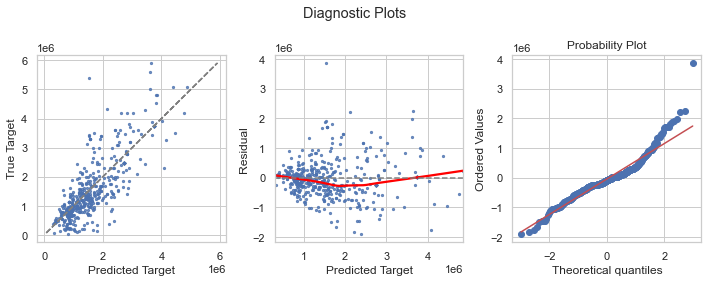

In [388]:
# y_predtlasso.predict(X_test)


lasso.fit(X_train_scaled,y_train)
y_test_pred = lin_reg_est.predict(X_test)

resid =  y_test - y_test_pred
train_score = lasso.score(X_train_scaled,y_train)
    # score fit model on validation data,  get predict and redidual value 
val_score = lasso.score(X_val_scaled,y_val)

print('Feature coefficient results: \n')
for feature, coef in zip(X3.columns, lasso.coef_):
    print(feature, ':', f'{coef:.2f}') 

y_pred = lasso.predict(X_test)

my_mae = mean_absolute_error(y_test, y_pred)

print('\nMAE:', my_mae)
# # Plot Y-predict vs Y-Actual
# plt.plot(y_train, y_train, color = 'red')
# plt.scatter(y_test, y_test_pred, alpha=.1)
# plt.ticklabel_format(style='plain') 
# plt.plot([0, 200], [0, 200])
# plt.savefig('Plot-Fitted_vs_Actual_TestSet')

# #Diagnosis
diagnostic_plots(y_test_pred, y_test,resid )

In [198]:
from sklearn.preprocessing import PolynomialFeatures
# Create polynomial features
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)

# Apply polynomial transformation to val set
X_val_poly = poly.transform(X_val)

# Fit a model using polynomial features
lr_poly = LinearRegression()
lr_poly.fit(X_train_poly,y_train)
lr_poly.score(X_train_poly,y_train)

0.7107623215480023

In [199]:
# Score on validation set
lr_poly.score(X_val_poly, y_val)

0.7091370508713488

In [200]:
# Don't forget to standard scale your data for regularized regression
scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)

# Apply the same scaler to val set
X_val_poly_scaled = scaler.transform(X_val_poly)

In [201]:
lasso=Lasso(alpha=10000)
lasso.fit(X_train_poly_scaled,y_train)

Lasso(alpha=10000)

In [133]:
# # Fit a LASSO model on full dataset using scaled, polynomial features
# poly = PolynomialFeatures(degree=2)
# X_poly = poly.fit_transform(X_train)

# scaler = StandardScaler()
# X_poly_scaled = scaler.fit_transform(X_poly)

# lasso = Lasso(alpha=10000)
# lasso.fit(X_poly_scaled,y)

# # Apply the same polynomial and scaling transformations to test set, then score
# X_test_poly = poly.transform(X_test)
# X_test_poly_scaled = scaler.transform(X_test_poly)

# lasso.score(X_test_poly_scaled, y_test)